In [2]:
import numpy as np
import torch
import einops
import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# taking 2hrs run again and save

In [3]:
# !pip install einops

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [3]:
true_deg = 9
obs_noise_std = 0.1
n_data = 500
seed = 15

np.random.seed(seed)
true_weights = np.random.randn(2, true_deg)
true_weights *= 1 / (np.arange(true_deg) + 1)**2
true_weights = einops.rearrange(true_weights, "c d -> (c d)")


def featurize(x, deg):
    f = np.stack([np.array([np.sin(d * x), np.cos(d * x)]) for d in range(1, deg+1)])
    return einops.rearrange(f, "d c n -> n (c d)")


def true_fn(x):
    f = featurize(x, true_deg)
    return f @ true_weights

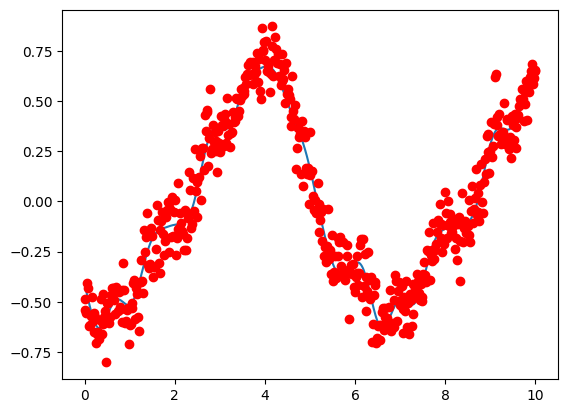

In [4]:
x = np.linspace(0., 10., 500)
true_y = true_fn(x)

np.random.seed(6)
x_train = x.copy()
np.random.shuffle(x_train)
y_train_true = true_fn(x_train)

y_train = y_train_true + np.random.randn(*y_train_true.shape) * obs_noise_std
plt.plot(x, true_y)
plt.plot(x_train[:n_data], y_train[:n_data], "ro")

In [5]:
n_train = 100

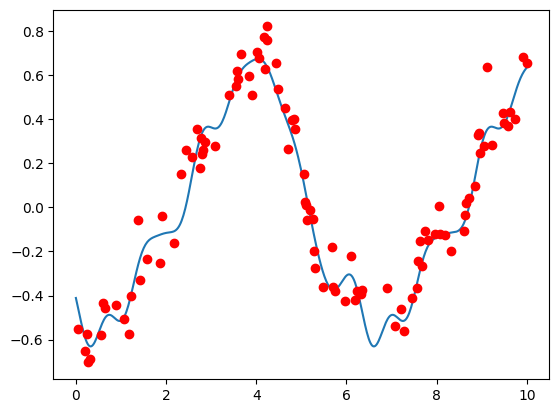

In [6]:
plt.plot(x, true_y)
plt.plot(x_train[:n_train], y_train[:n_train], "ro")

In [7]:
def get_marginal_cov(x, prior_cov, noise_std):
    return x @ prior_cov @ x.T + noise_std**2 * np.eye(len(x))


def get_marginal_likelihood(x, y, prior_cov, noise_std):
    cov = get_marginal_cov(x, prior_cov, noise_std)
    cov = torch.from_numpy(cov).float()
    marginal_dist = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.zeros((len(x),)),
        covariance_matrix=cov,
        validate_args=True)
    return marginal_dist.log_prob(torch.from_numpy(y).float())


def get_posterior(x, y, prior_cov, noise_std):
#     inv_cov = x.T @ x / noise_std**2 + np.eye(len(x.T)) / alpha**2
    inv_cov = x.T @ x / noise_std**2 + np.linalg.inv(prior_cov)
    cov = np.linalg.inv(inv_cov)
    mu = cov @ x.T @ y / noise_std**2
    return mu, cov


# def get_posterior_predictive(x_train, x_test, ):

## Deg 4

In [8]:
alpha = 1.
deg = 3
n_features = deg * 2
x_train_lin = featurize(x_train, deg)

In [9]:
get_marginal_likelihood(x_train_lin[:n_train], y_train[:n_train],
                        np.eye(n_features) * alpha**2, obs_noise_std)

tensor(53.8036)

In [10]:
n_observed = 85
n_orders = 200

all_cmlls = []
for i in range(n_orders):
    order = np.arange(n_train)
    np.random.shuffle(order)
    observed_idx = order[:n_observed]

    all_cmlls.append((get_marginal_likelihood(x_train_lin[:n_train], y_train[:n_train], np.eye(n_features) * alpha**2, obs_noise_std) -
              get_marginal_likelihood(x_train_lin[observed_idx], y_train[observed_idx], np.eye(n_features) * alpha**2, obs_noise_std)))

all_cmlls = np.array(all_cmlls)
all_cmlls.mean()

10.717725

In [11]:
alpha = 1.
prior_cov = np.eye(n_features) * alpha**2
mu, sigma = get_posterior(x_train_lin[:n_train], y_train[:n_train], prior_cov, obs_noise_std)

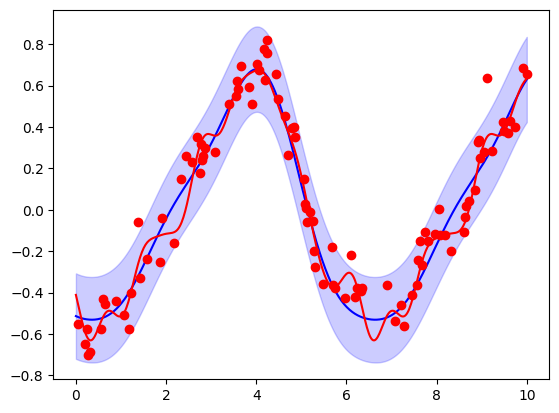

In [12]:
x_test_lin = featurize(x, deg)
pred_mu = x_test_lin @ mu.T
pred_sigma2 = obs_noise_std**2 + np.einsum("i m, mn, in -> i", x_test_lin, sigma, x_test_lin)
pred_sigma = np.sqrt(pred_sigma2)

plt.plot(x, pred_mu, color="b")
plt.fill_between(x, pred_mu + pred_sigma * 2, pred_mu - pred_sigma * 2, alpha=0.2, color="b")
plt.plot(x, true_y, color="r")
plt.plot(x_train[:n_train], y_train[:n_train], "ro")

In [15]:
# np.savez("plots/data/fourier_m3",
#         x_train=x_train[:n_train],
#         y_train=y_train[:n_train],
#         x_test=x,
#         y_test=true_y,
#         pred_mu=pred_mu,
#         pred_sigma=pred_sigma,
#         param_mu=mu,
#         param_cov=sigma)

## Deg-10 polynomial

In [16]:
alpha = 1.
deg = 9
n_features = deg * 2
x_train_lin = featurize(x_train, deg)

In [17]:
get_marginal_likelihood(x_train_lin[:n_train], y_train[:n_train],
                        np.eye(n_features) * alpha**2, obs_noise_std)

tensor(28.9162)

In [18]:
n_observed = 85
n_orders = 200

all_cmlls = []
for i in range(n_orders):
    order = np.arange(n_train)
    np.random.shuffle(order)
    observed_idx = order[:n_observed]

    all_cmlls.append((get_marginal_likelihood(x_train_lin[:n_train], y_train[:n_train], np.eye(n_features) * alpha**2, obs_noise_std) -
              get_marginal_likelihood(x_train_lin[observed_idx], y_train[observed_idx], np.eye(n_features) * alpha**2, obs_noise_std)))

all_cmlls = np.array(all_cmlls)
all_cmlls.mean()

12.877536

In [19]:
alpha = 1.
prior_cov = np.eye(n_features) * alpha**2
mu, sigma = get_posterior(x_train_lin[:n_train], y_train[:n_train], prior_cov, obs_noise_std)

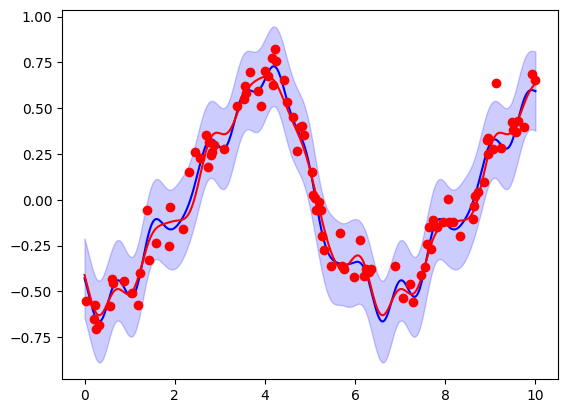

In [20]:
x_test_lin = featurize(x, deg)
pred_mu = x_test_lin @ mu.T
pred_sigma2 = obs_noise_std**2 + np.einsum("i m, mn, in -> i", x_test_lin, sigma, x_test_lin)
pred_sigma = np.sqrt(pred_sigma2)

plt.plot(x, pred_mu, color="b")
plt.fill_between(x, pred_mu + pred_sigma * 2, pred_mu - pred_sigma * 2, alpha=0.2, color="b")
plt.plot(x, true_y, color="r")
plt.plot(x_train[:n_train], y_train[:n_train], "ro")

In [21]:
# np.savez("plots/data/fourier_m9",
#         x_train=x_train[:n_train],
#         y_train=y_train[:n_train],
#         x_test=x,
#         y_test=true_y,
#         pred_mu=pred_mu,
#         pred_sigma=pred_sigma,
#         param_mu=mu,
#         param_cov=sigma)

## Deg 10 corrected

In [22]:
alpha = 1.
deg = 9
n_features = deg * 2
x_train_lin = featurize(x_train, deg)

In [23]:
prior_stds = np.ones((2, deg)) / (np.arange(deg) + 1)**2
prior_stds = einops.rearrange(prior_stds, "c d -> (c d)")
prior_cov = np.eye(n_features) * prior_stds
# prior_cov = np.eye(n_features) * alpha**2
mu, sigma = get_posterior(x_train_lin[:n_train], y_train[:n_train], prior_cov, obs_noise_std)

In [24]:
get_marginal_likelihood(x_train_lin[:n_train], y_train[:n_train],
                        prior_cov, obs_noise_std)

tensor(54.2337)

In [25]:
n_observed = 85
n_orders = 200

all_cmlls = []
for i in range(n_orders):
    order = np.arange(n_train)
    np.random.shuffle(order)
    observed_idx = order[:n_observed]

    all_cmlls.append((get_marginal_likelihood(x_train_lin[:n_train], y_train[:n_train], prior_cov, obs_noise_std) -
              get_marginal_likelihood(x_train_lin[observed_idx], y_train[observed_idx], prior_cov, obs_noise_std)))

all_cmlls = np.array(all_cmlls)
all_cmlls.mean()

13.276567

Text(0.5, 1.0, 'Corrected prior model fit')

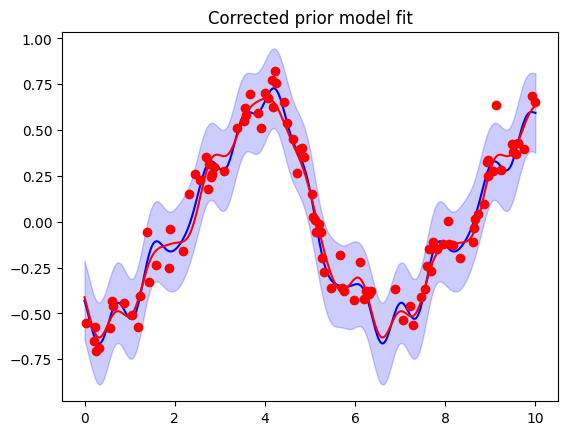

In [26]:
x_test_lin = featurize(x, deg)
pred_mu = x_test_lin @ mu.T
pred_sigma2 = obs_noise_std**2 + np.einsum("i m, mn, in -> i", x_test_lin, sigma, x_test_lin)
pred_sigma = np.sqrt(pred_sigma2)

plt.plot(x, pred_mu, color="b")
plt.fill_between(x, pred_mu + pred_sigma * 2, pred_mu - pred_sigma * 2, alpha=0.2, color="b")
plt.plot(x, true_y, color="r")
plt.plot(x_train[:n_train], y_train[:n_train], "ro")
plt.title("Corrected prior model fit")

In [27]:
# np.savez("plots/data/fourier_m9c",
#         x_train=x_train[:n_train],
#         y_train=y_train[:n_train],
#         x_test=x,
#         y_test=true_y,
#         pred_mu=pred_mu,
#         pred_sigma=pred_sigma,
#         param_mu=mu,
#         param_cov=sigma)

## Deg vs Marginal likelihood 

In [32]:
import torch
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_orders = 200
deg_cmlls = {}

for deg in [3, 9]:
    n_features = deg * 2
    x_train_lin = torch.tensor(featurize(x_train, deg)).float().to(device)  # Convert to tensor and move to GPU
    y_train = torch.tensor(y_train).float().to(device)  # Convert y_train to tensor and move to GPU

    all_cmlls = []
    for i in tqdm(range(n_orders)):
        order = torch.randperm(n_data).to(device)  # Random permutation on GPU
        order_mlls = []

        for n_observed in range(1, n_data):
            observed_idx = order[:n_observed]
            prior_cov = torch.eye(n_features, device=device) * alpha**2  # Create prior covariance matrix on GPU
            order_mlls.append(get_marginal_likelihood(
                x_train_lin[observed_idx], y_train[observed_idx], prior_cov, obs_noise_std
            ))

        order_mlls = torch.stack(order_mlls)  # Keep order_mlls as a tensor
        all_cmlls.append(order_mlls.cpu().numpy())  # Move to CPU and convert to NumPy array

    all_cmlls = np.array(all_cmlls)  # Convert list of arrays to NumPy array
    deg_cmlls[deg] = all_cmlls.mean(axis=0)  # Store mean for the degree


/tmp/ipykernel_3392750/3943881750.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float().to(device)  # Convert y_train to tensor and move to GPU
  0%|          | 0/200 [00:00<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [1]:
n_orders = 200
deg_cmlls = {}

for deg in [3, 9]:
    n_features = deg * 2
    x_train_lin = featurize(x_train, deg)

    all_cmlls = []
    for i in tqdm.tqdm(range(n_orders)):
        order = np.arange(n_data)
        np.random.shuffle(order)
        order_mlls = []

        for n_observed in range(1, n_data):
            observed_idx = order[:n_observed]
            prior_cov = np.eye(n_features) * alpha**2
            order_mlls.append(get_marginal_likelihood(x_train_lin[observed_idx], y_train[observed_idx],
                                                     prior_cov, obs_noise_std))
        order_mlls = np.array(order_mlls)
        all_cmlls.append(order_mlls)

    all_cmlls = np.array(all_cmlls)
    all_cmlls = all_cmlls.mean(axis=0)
    deg_cmlls[deg] = all_cmlls

NameError: name 'featurize' is not defined

In [31]:
for deg in [3, 9]:
    plt.plot(deg_cmlls[deg][1:] - deg_cmlls[deg][:-1], label=f"deg={deg}")
plt.legend(fontsize=14)

KeyError: 3

In [32]:
n_orders = 200
corrected_deg_cmlls = {}

for deg in [9]:
    n_features = deg * 2
    x_train_lin = featurize(x_train, deg)
    prior_stds = np.ones((2, deg)) / (np.arange(deg) + 1)**2
    prior_stds = einops.rearrange(prior_stds, "c d -> (c d)")
    prior_cov = np.eye(n_features) * prior_stds

    all_cmlls = []
    for i in tqdm.tqdm(range(n_orders)):
        order = np.arange(n_data)
        np.random.shuffle(order)
        order_mlls = []

        for n_observed in range(1, n_data):
            observed_idx = order[:n_observed]
            order_mlls.append(get_marginal_likelihood(x_train_lin[observed_idx], y_train[observed_idx],
                                                     prior_cov, obs_noise_std))
        order_mlls = np.array(order_mlls)
        all_cmlls.append(order_mlls)

    all_cmlls = np.array(all_cmlls)
    all_cmlls = all_cmlls.mean(axis=0)
    corrected_deg_cmlls[deg] = all_cmlls

  0%|          | 1/200 [00:26<1:28:25, 26.66s/it]


KeyboardInterrupt: 

Text(0, 0.5, '$p(D_n | D_{\\leq n-1})$')

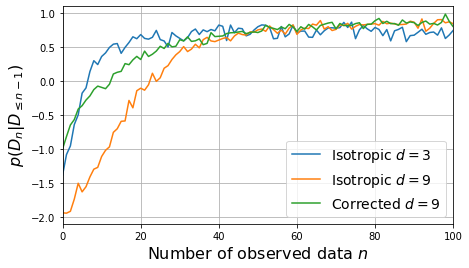

In [148]:
plt.figure(figsize=(7, 4))
for deg in [3, 9]:
    plt.plot(deg_cmlls[deg][1:] - deg_cmlls[deg][:-1], label=f"Isotropic $d={deg}$", lw=1.5)
plt.plot(corrected_deg_cmlls[9][1:] - corrected_deg_cmlls[9][:-1], label=f"Corrected $d={deg}$", lw=1.5)
plt.grid()
plt.legend(fontsize=14)
plt.xlabel(r"Number of observed data $n$", fontsize=16)
# plt.text(100, -1.5, "MLL prefers $d=3$", rotation=90, fontsize=14)
# plt.text(250, -1.5, "MLL prefers $d=10$", rotation=90, fontsize=14)
# plt.vlines(180, -2.1, 1.5, color="k", linestyle="dashed")

plt.ylim(-2.1, 1.1)
plt.xlim(0, 100)

plt.ylabel(r"$p(D_n | D_{\leq n-1})$", fontsize=16)

In [155]:
np.savez("plots/data/fourier_cmll_results",
        m3_cmlls=deg_cmlls[3],
        m9_cmlls=deg_cmlls[9],
        m9c_cmlls=corrected_deg_cmlls[9],
        )

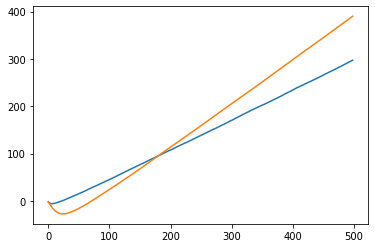

In [276]:
plt.plot(deg_cmlls[3])
plt.plot(deg_cmlls[10])

## Parameter optimization: MLL

In [522]:
deg = 3
n_features = deg + 1

x_train_poly = featurize(x_train, deg)

In [523]:
alphas = np.linspace(0.05, 30., 1000)
mlls = [get_marginal_likelihood(x_train_poly[:n_data], 
                                y_train[:n_data], 
                                np.eye(n_features) * alpha**2,
                                obs_noise_std)
        for alpha in alphas]

Text(0.5, 1.0, 'Marginal log-likelihood in polynomial model')

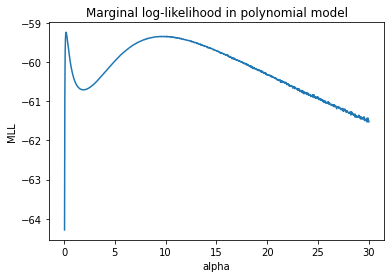

In [524]:
plt.plot(alphas, mlls)
plt.xlabel("alpha")
plt.ylabel("MLL")
plt.title("Marginal log-likelihood in polynomial model")

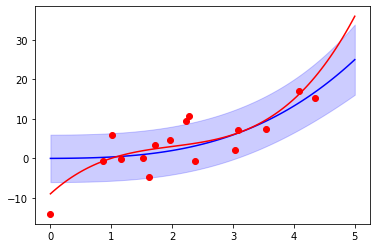

In [526]:
alpha = alphas[np.argmax(mlls)]
x_train_poly = featurize(x_train, deg)
prior_cov = np.eye(n_features) * alpha**2

mu, sigma = get_posterior(x_train_poly[:n_data], y_train[:n_data], prior_cov, obs_noise_std)

x_test_poly = featurize(x, 3)
pred_mu = x_test_poly @ mu.T
pred_sigma2 = obs_noise_std**2 + np.einsum("i m, mn, in -> i", x_test_poly, sigma, x_test_poly)
pred_sigma = np.sqrt(pred_sigma2)

plt.plot(x, pred_mu, color="b")
plt.fill_between(x, pred_mu + pred_sigma * 2, pred_mu - pred_sigma * 2, alpha=0.2, color="b")
plt.plot(x, true_y, color="r")
plt.plot(x_train[:n_data], y_train[:n_data], "ro")

### Conditional MLL

In [527]:
deg = 3
n_features = deg + 1

x_train_poly = featurize(x_train, deg)

Text(0.5, 1.0, 'Conditional log-likelihood in polynomial model, 14 observed')

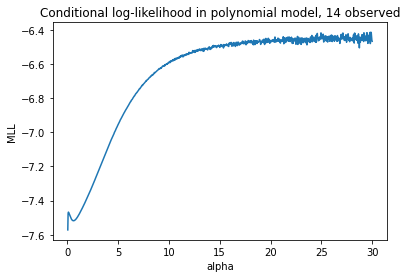

In [528]:
alphas = np.linspace(0.05, 30., 1000)
n_observed = 14
n_orders = 20

all_cmlls = []
for i in range(n_orders):
    order = np.arange(n_data)
    np.random.shuffle(order)
    observed_idx = order[:n_observed]

    cmlls = [(get_marginal_likelihood(x_train_poly[:n_data], y_train[:n_data], np.eye(n_features) * alpha**2, obs_noise_std) -
              get_marginal_likelihood(x_train_poly[observed_idx], y_train[observed_idx], np.eye(n_features) * alpha**2, obs_noise_std))
            for alpha in alphas]
    all_cmlls.append(cmlls)

all_cmlls = np.array(all_cmlls)
avg_cmlls = all_cmlls.mean(axis=0)
plt.plot(alphas, avg_cmlls)
plt.xlabel("alpha")
plt.ylabel("MLL")
plt.title("Conditional log-likelihood in polynomial model, {} observed".format(n_observed))

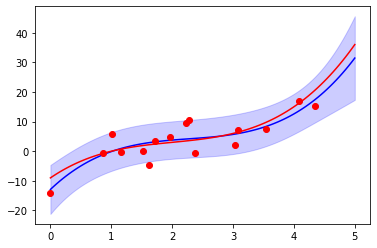

In [529]:
alpha = alphas[np.argmax(avg_cmlls)]
x_train_poly = featurize(x_train, deg)
prior_cov = np.eye(n_features) * alpha**2

mu, sigma = get_posterior(x_train_poly[:n_data], y_train[:n_data], prior_cov, obs_noise_std)

x_test_poly = featurize(x, 3)
pred_mu = x_test_poly @ mu.T
pred_sigma2 = obs_noise_std**2 + np.einsum("i m, mn, in -> i", x_test_poly, sigma, x_test_poly)
pred_sigma = np.sqrt(pred_sigma2)

plt.plot(x, pred_mu, color="b")
plt.fill_between(x, pred_mu + pred_sigma * 2, pred_mu - pred_sigma * 2, alpha=0.2, color="b")
plt.plot(x, true_y, color="r")
plt.plot(x_train[:n_data], y_train[:n_data], "ro")

## Tuning the deg-3 coefficient

### MLL

In [577]:
def get_prior_cov(alpha, d, alpha_0=3.):
#     alpha_0 = 10.
    cov = alpha_0**2 * np.eye(d)
    cov[1, 1] = alpha**2
    return cov

In [578]:
deg = 3
n_features = deg + 1

x_train_poly = featurize(x_train, deg)

In [579]:
alphas = np.linspace(0.05, 30., 1000)
mlls = [get_marginal_likelihood(x_train_poly[:n_data], 
                                y_train[:n_data], 
                                get_prior_cov(alpha, n_features),
                                obs_noise_std)
        for alpha in alphas]

Text(0.5, 1.0, 'Marginal log-likelihood in polynomial model')

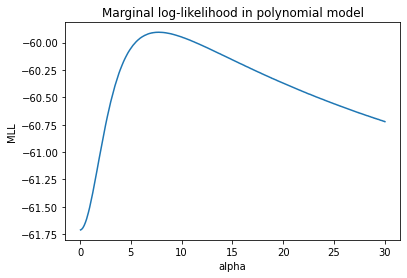

In [580]:
plt.plot(alphas, mlls)
plt.xlabel("alpha")
plt.ylabel("MLL")
plt.title("Marginal log-likelihood in polynomial model")

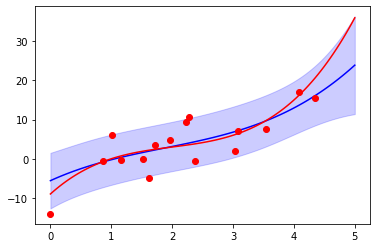

In [584]:
alpha = alphas[np.argmax(mlls)]
# alpha = 10.
x_train_poly = featurize(x_train, deg)
prior_cov = get_prior_cov(alpha, n_features)

mu, sigma = get_posterior(x_train_poly[:n_data], y_train[:n_data], prior_cov, obs_noise_std)

x_test_poly = featurize(x, 3)
pred_mu = x_test_poly @ mu.T
pred_sigma2 = obs_noise_std**2 + np.einsum("i m, mn, in -> i", x_test_poly, sigma, x_test_poly)
pred_sigma = np.sqrt(pred_sigma2)

plt.plot(x, pred_mu, color="b")
plt.fill_between(x, pred_mu + pred_sigma * 2, pred_mu - pred_sigma * 2, alpha=0.2, color="b")
plt.plot(x, true_y, color="r")
plt.plot(x_train[:n_data], y_train[:n_data], "ro")